# 1. Setup

## 1.1 Import Packages

In [1]:
#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# for splitting of the dataset
from sklearn.model_selection import train_test_split

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import MinMaxScaler

#ML-Models: Classification
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn. ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import AdaBoostClassifier

#Building clustering model
from sklearn.cluster import KMeans 

# for getting metrics
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score,silhouette_samples

# model selection
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
# Define a simple scoring function
from cachetools import cached

## 1.2 Connect to Snowflake

In [2]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [3]:
session.sql("ALTER WAREHOUSE TASTY_BI_WH SET WAREHOUSE_SIZE = MEDIUM").collect()

[Row(status='Statement executed successfully.')]

## 1.3 Gathering Data as Snowpark DataFrame

In [4]:
# Orders_V
# contains orders, trucks, shift information
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
# Customer Loyalty
# contains information on signed up members
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")

locations= session.table("frostbyte_tasty_bytes.raw_pos.location")

menu= session.table("frostbyte_tasty_bytes.raw_pos.menu")
#Sentiment_Survey_ds
# contains NPS score
SENTIMENT_DATA = session.table("ngee_ann_polytechnic_frostbyte_data_share.raw_survey.sentiment_survey_ds")
# Truck information data
TRUCK_DATA = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.truck")
# Comparison Data
NPS_COMPARE = session.table("NPS_COMPARE")

# 2. Data Exploration 

## 2.0 Model Value Towards Tasty Byte KPI

### 2.0.1 Define function - Remove Duplicate Columns from Joins

In [5]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

### 2.0.2 Model Value Towards Tasty Byte KPI

The initial objectives of the model is to work towards improving two main KPI's. This section includes information regarding the correlation of identifying customer churn (or in the case of this stage, days to next order).

The idea behind our model is that by identifying when customers will churn the marketing team can take steps to carry out targeted marketing to be able to prevent that and in turn improve NPS score and Sales YOY

In [6]:
# # gather NPS required columns to analyse
# SENTIMENT = TRUCK_DATA.join(SENTIMENT_DATA, SENTIMENT_DATA["TRUCK_ID"] == TRUCK_DATA["TRUCK_ID"], "inner")

# SENTIMENT2 = SENTIMENT.dropna()

# # setting up NPS Score by year, month and specific year months to compare
# AVG_NPS_SCORE = SENTIMENT2.with_column("YEAR", F.year("SURVEY_TS"))
# AVG_NPS_SCORE = AVG_NPS_SCORE.with_column("MONTH", F.month("SURVEY_TS"))
# AVG_NPS_SCORE = AVG_NPS_SCORE.with_column("YEAR_MONTH", F.concat(F.col("YEAR"), F.col("MONTH")))

# AVG_NPS_SCORE_YEAR = AVG_NPS_SCORE.groupBy(F.col("YEAR")).agg(F.avg("NPS_SCORE"))
# AVG_NPS_SCORE_MONTH = AVG_NPS_SCORE.groupBy(F.col("MONTH")).agg(F.avg("NPS_SCORE"))
# AVG_NPS_SCORE_YM = AVG_NPS_SCORE.groupBy(F.col("YEAR"), F.col("MONTH")).agg(F.avg("NPS_SCORE"))

# # setting up comparison table (i.e. DTNO to KPI)
# NPS_COMPARE = NPS_COMPARE.with_column("YEAR", F.year("DATE"))
# NPS_COMPARE = NPS_COMPARE.with_column("MONTH", F.month("DATE"))
# NPS_COMPARE = NPS_COMPARE.with_column("YEAR_MONTH", F.concat(F.col("YEAR"), F.col("MONTH")))

# AVG_DTNO_YEAR = NPS_COMPARE.groupBy(F.col("YEAR")).agg(F.avg('"DAYS_TO_NEXT_ORDER"'))
# AVG_DTNO_MONTH = NPS_COMPARE.groupBy(F.col("MONTH")).agg(F.avg('"DAYS_TO_NEXT_ORDER"'))
# AVG_DTNO_YM = NPS_COMPARE.groupBy(F.col("YEAR"),F.col("MONTH")).agg(F.avg('"DAYS_TO_NEXT_ORDER"'))

# AVG_SALES_YM = NPS_COMPARE.groupBy(F.col("YEAR"),F.col("MONTH")).agg(F.avg('"ORDER_TOTAL"'))
# SUM_SALES_YM = NPS_COMPARE.groupBy(F.col("YEAR"),F.col("MONTH")).agg(F.sum('"ORDER_TOTAL"'))

Here we are comparing the average days to next order, which is what our model is predicting for in terms of the churn value, with the average net promoter score of the respective year. We can see that there exists a correlation that does not fit what we had set out to achieve.

There is a positive correlation between the two values across the years and that is reflected as well when taking a look at the month and year month levels (Which is not shown in the jupyter notebook).

It is expected that the two values do not have the correlation that we were looking for and hence we will be dropping the NPS as our target for this model due to this finding.

In [7]:
# # comparing the NPS with the DTNO VALUE
# DTNO_TO_NPS_YEAR = AVG_DTNO_YEAR.join(AVG_NPS_SCORE_YEAR, AVG_DTNO_YEAR["YEAR"] == AVG_NPS_SCORE_YEAR["YEAR"])

# SDTNO_TO_NPS_YEAR_LOW_COL = remove_dup_join_col(DTNO_TO_NPS_YEAR)

# SDTNO_TO_NPS_YEAR_LOW_COL.show()

On the other hand we do see that the average days to next orders has a relationship with average sales by month that we can work with.

We see that when the average days to next orders increase the total sales within the month decrease, and when average days to next orders decrease the total sales increase this means the customer recursion matters to the revenue.

This acts as a proxy value to the KPI of revenue and ties our models output towards achieving company goals. As by taking actions to reduce the days to next order or churn rate down we can maximise our profits through creating loyal customers and encouraging customers to use the service more.

In [8]:
# SALES_VS_DTNO = SUM_SALES_YM.join(AVG_DTNO_YM, (SUM_SALES_YM["YEAR"] == AVG_DTNO_YM["YEAR"])&(SUM_SALES_YM["MONTH"] == AVG_DTNO_YM["MONTH"]))

# SALES_VS_DTNO_LOW_COL = remove_dup_join_col(SALES_VS_DTNO)

# SALES_VS_DTNO_LOW_COL.orderBy(F.col('YEAR'),F.col('MONTH').asc()).show()

## 2.2 Visualise the Data

### 2.2.2 Members in Country

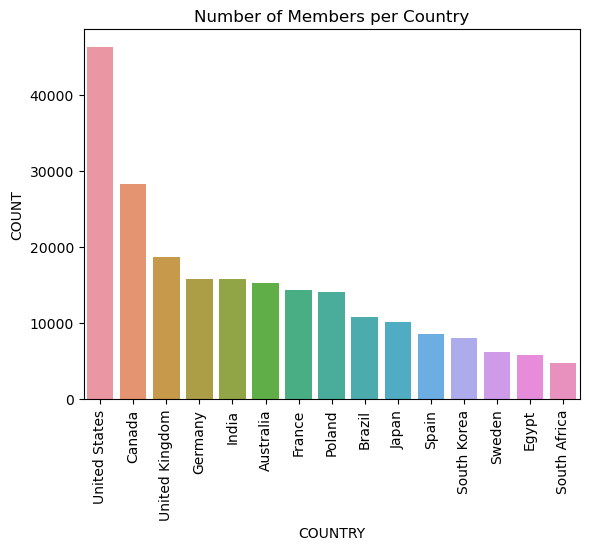

In [9]:
# Unique members
unique_Members=tasty_bytes_customer_loyalty.group_by(F.col('Country')).count().to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=unique_Members)
plt.xticks(rotation=90)
plt.title('Number of Members per Country')
plt.show()

It can be seen that the Unite States has the most number of members of all the countries Tasty Bytes serves. By choosing the United States, we will have the largest possible sample size of members to most closely mimic a global dataset.

### 2.2.3 Total number of Transactions

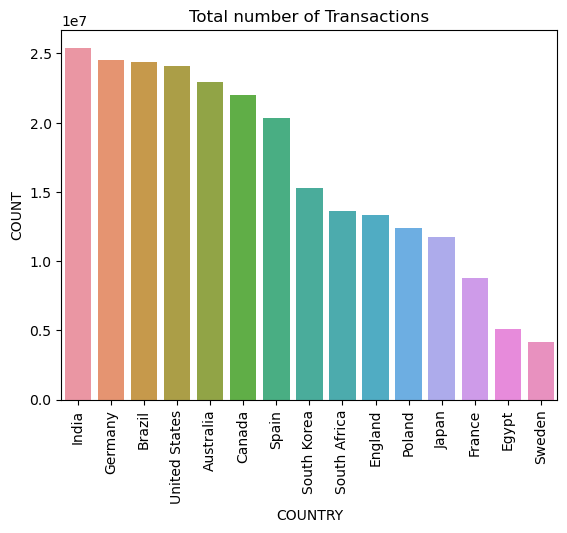

In [10]:
# Number of unique transactions
unique_Transactions=tasty_bytes_orders_v.group_by(F.col('COUNTRY')).agg(F.countDistinct('ORDER_ID').alias('COUNT')).to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=unique_Transactions)
plt.xticks(rotation=90)
plt.title('Total number of Transactions')
plt.show()

It can be seen that the United States has the 4th most number of transactions. We are able to get a balance of the number of members with sufficent data on each member from their orders

## 2.3 Churn Rate by Country

### 2.3.1 Get Churn Cut Off date by Country

In [11]:
#Get last transaction date for each country
last_tran_country = tasty_bytes_orders_v.group_by(F.col('COUNTRY')).max(F.to_date(F.col('ORDER_TS'))).to_pandas()

#Get assumed churned date which is two weeks before last transaction date, then get total number of customers in the assumed time period
last_tran_country['CHURN_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=14)
last_tran_country['CUSTOMER_COUNT_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=44)

#Make pandas dataframe into a snowpark dataframe
last_tran_country_sdf=session.createDataFrame(last_tran_country)

#Merge 
last_tran_country_sdf_join = last_tran_country_sdf.join(
    right=tasty_bytes_orders_v,
    on="COUNTRY",
    how="inner"
)

We get the churn cut off date by country. This is done by subtracting 14 days from the latest order date, with 14 days being the assumed churn period. These values are compared with the time stamp so that we can identify which customers were active within the time frame and how many left. 

### 2.3.2 Calculate Churn Rate by Country

In [12]:
#Filter dataframe to the assumed time period
df = last_tran_country_sdf_join[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CUSTOMER_COUNT_DATE"]]

#Filter to get churned members dataset
df2 = df[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CHURN_DATE"]]

#Number of customers before churn date
cust_bef = df.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_BEF'))
#Number of customers after churn date
cust_aft = df2.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_AFT'))

#Merge
calculator = cust_aft.join(
    right=cust_bef,
    on="COUNTRY",
    how="inner"
)
calc = calculator.to_pandas()

#Calculate Churn rate 
calc["CHURN_RATE"] = (((calc["COUNT_BEF"] - calc["COUNT_AFT"]) / calc["COUNT_BEF"]) * 100)
churn_Rate=calc.sort_values(by='CHURN_RATE',ascending=False)

We calculated the churn rate for each country. This is done by calculating the number of customers at the start and end of churn period. After doing so, the churn rate is grouped by the different countries.

### 2.3.3 Visualise Churn Rate

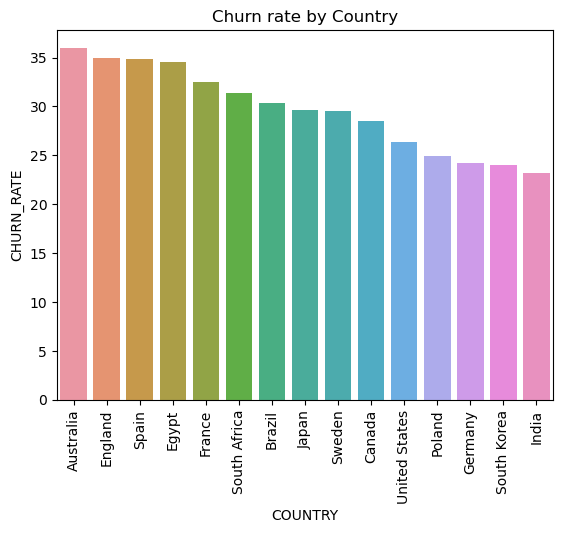

In [13]:
#Churn rate by Country
sns.barplot(x='COUNTRY',y='CHURN_RATE',data=churn_Rate)
plt.xticks(rotation=90)
plt.title('Churn rate by Country')
plt.show()

<b>We decided to work on United States as it has the most number of customers, a high number of customers and quite a high Churn Rate.

# 3. Data Engineering

## 3.1 Generate new Columns

In [14]:
#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=tasty_bytes_customer_loyalty,
    on="CUSTOMER_ID",
    how="inner"
)

In [15]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)

#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])

### 3.1.1 Get Latest Order Date

In [16]:
# called `orders` with columns `customer_id` and `order_ts`
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').desc())

orders_with_rank = remove_dup.withColumn('rank', F.rank().over(window_spec))

# Get max order of each customer
max_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')


In [17]:
# Rename columns
max_order_ts = max_order_ts.withColumnRenamed('ORDER_TS','Max_Order_TS')

In [18]:
# Merge with second max order dataframe
max_Order=remove_dup.join(right=max_order_ts,on='CUSTOMER_ID',how='inner')

#Filter out last purchase
filtered_df = max_Order

In [19]:
cust_Order = tasty_bytes_orders_v.dropDuplicates(['ORDER_ID'])
cust_Order =cust_Order.with_column('YEAR', F.year("ORDER_TS"))
cust_Order =cust_Order.with_column('MONTH',F.month("ORDER_TS"))
cust_sales_by_year=cust_Order.group_by('YEAR').agg(F.round(F.sum('ORDER_TOTAL')/1000000,2).alias('TOTAL_SALES_IN_MILLIONS'))

In [20]:
cust_orders_by_year=cust_Order.group_by('YEAR').agg(F.round(F.count('ORDER_ID')/1000000,2).alias('TOTAL_ORDERS_IN_MILLIONS'))

In [22]:
memb_sales=filtered_df.with_column('YEAR', F.year("ORDER_TS"))
memb_sales=memb_sales.with_column('MONTH',F.month("ORDER_TS"))
memb_sales_by_year=memb_sales.group_by('YEAR').agg(F.round(F.sum('ORDER_TOTAL')/1000000,2).alias('TOTAL_MEMBER_SALES_IN_MILLIONS'))

In [23]:
memb_orders_by_year=memb_sales.group_by('YEAR').agg(F.round(F.count('ORDER_ID')/1000000,2).alias('TOTAL_MEMBER_ORDERS_IN_MILLIONS'))

In [24]:
memb_Sign_Up = filtered_df.dropDuplicates(['CUSTOMER_ID'])
memb_Sign_Up=memb_Sign_Up.with_column('SIGN_UP_YEAR', F.year('SIGN_UP_DATE'))
memb_sign_up_by_year=memb_Sign_Up.group_by('SIGN_UP_YEAR').agg(F.round(F.count('CUSTOMER_ID')/1000,2).alias('TOTAL_SIGN_UPS_IN_THOUSANDS'))

In [26]:
#Merge to get loyal customers orders
sales_Analysis=cust_sales_by_year.join(
    right=memb_sales_by_year,
    on="YEAR",
    how="inner"
)
sales_Analysis=sales_Analysis.join(
    right=cust_orders_by_year,
    on="YEAR",
    how="inner"
)

sales_Analysis=sales_Analysis.join(
    right=memb_orders_by_year,
    on="YEAR",
    how="inner"
)
sales_Analysis=sales_Analysis.sort('YEAR')

In [27]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.orderBy("YEAR")

# Add a column with the date of the prior order for each customer 
sales_Analysis = sales_Analysis.withColumn("PREVIOUS_YEAR_SALES_IN_MILLIONS", F.lag("TOTAL_SALES_IN_MILLIONS").over(window_spec))

In [28]:
sales_Analysis=sales_Analysis.withColumn('YOY_SALES%',F.round(((F.col('TOTAL_SALES_IN_MILLIONS')-F.col("PREVIOUS_YEAR_SALES_IN_MILLIONS"))/ F.col("PREVIOUS_YEAR_SALES_IN_MILLIONS")) * 100,0))
sales_Analysis=sales_Analysis.withColumn('MEMBER_SALES%',F.round((F.col('TOTAL_MEMBER_SALES_IN_MILLIONS')/F.col("TOTAL_SALES_IN_MILLIONS"))*100,2))

In [ ]:
sales_Analysis.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"YEAR"  |"TOTAL_SALES_IN_MILLIONS"  |"TOTAL_MEMBER_SALES_IN_MILLIONS"  |"TOTAL_ORDERS_IN_MILLIONS"  |"TOTAL_MEMBER_ORDERS_IN_MILLIONS"  |"PREVIOUS_YEAR_SALES_IN_MILLIONS"  |"YOY_SALES%"  |"MEMBER_SALES%"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|2019    |192.35                     |18.80                             |4.90                        |0.51                               |NULL                               |NULL          |9.77             |
|2020    |1381.94                    |122.16                            |33.13                       |2.95                               |192.35                        

In [ ]:
stop

### 3.1.2 RFM (Recency, Freqency, Monetary)

In [29]:
# Get last purchase date as a variable
lastdate=filtered_df.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = filtered_df.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = filtered_df.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = filtered_df.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')


This code is used to get RFM, Recency, Frequency, and Monetary for each customer. The purpose of doing this is to generate new features and show the customer's behavioural data.

### 3.1.3 Average Time Difference, Max and Min Days without Purchase

In [30]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the prior order for each customer 
orders_df = filtered_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.lag("DATE").over(window_spec))

# Calculate the number of days between the prior order and the current order for each customer and menu item
orders_df = orders_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.datediff(col1="DAYS_SINCE_PRIOR_ORDER", col2="DATE",part='day'))
orders_df = orders_df.na.drop(subset=["DAYS_SINCE_PRIOR_ORDER"])

# Calculate the average purchase time difference for each customer
avg_time_diff=orders_df.group_by('CUSTOMER_ID').agg(F.round(F.avg('DAYS_SINCE_PRIOR_ORDER'),0).alias('Avg_Days_Between_Purchase'))

# Max Days without Purchase
max_days=orders_df.group_by('CUSTOMER_ID').agg(F.max('DAYS_SINCE_PRIOR_ORDER').alias('Max_Days_Without_Purchase'))

# Min Days without Purchase
min_days=orders_df.group_by('CUSTOMER_ID').agg(F.min('DAYS_SINCE_PRIOR_ORDER').alias('Min_Days_Without_Purchase'))

This code is used to get the average purchase time difference for each customers. This is done by calculating the most number of days a customer has gone without purchasing and the least number of days the customer has gone without purchasing. These features are also to show the behavioural information of each customer.

### 3.1.4 Creating Age and getting Customer's Gender, Marital Status and Country

In [31]:
# Get Customer demographic
cust_demo=tasty_bytes_customer_loyalty.select('CUSTOMER_ID','BIRTHDAY_DATE','GENDER','MARITAL_STATUS','COUNTRY','CITY','SIGN_UP_DATE','CHILDREN_COUNT')

# get AGE variable
cust_demo = cust_demo.withColumn("AGE", F.datediff('year', F.col("BIRTHDAY_DATE"),F.lit(lastdate)))

# Show
cust_demo.show()

---------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"BIRTHDAY_DATE"  |"GENDER"     |"MARITAL_STATUS"  |"COUNTRY"  |"CITY"          |"SIGN_UP_DATE"  |"CHILDREN_COUNT"  |"AGE"  |
---------------------------------------------------------------------------------------------------------------------------------------------
|1              |1953-12-01       |Female       |Single            |Germany    |Hamburg         |2019-02-19      |0                 |69     |
|2              |1973-09-21       |Male         |Single            |Brazil     |Rio de Janeiro  |2019-10-07      |0                 |49     |
|3              |2000-09-04       |Female       |Married           |Poland     |Krakow          |2020-09-11      |2                 |22     |
|4              |1950-03-05       |Female       |Single            |Poland     |Krakow          |2021-09-09      |1                 |72     |
|5    

We added a new column called "AGE" which contains the age of the customer at the time of the latest transaction. We also retrieved new columns like the customer's gender, marital status and country.

### Attempted Improvements to the model

#### Improved the Model

In [32]:
# Number of locations visited
num_of_locations_visited=filtered_df.group_by('CUSTOMER_ID').agg(F.countDistinct('LOCATION_ID').alias('NUM_OF_LOCATIONS_VISITED'))

In [33]:
# Add Length of relationship

window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').asc())

orders_with_rank = filtered_df.withColumn('rank', F.rank().over(window_spec))

# Get max order of each customer
first_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')

# Join the first_orders and last_orders DataFrames on customer_id
joined_orders = first_order_ts.join(max_order_ts, 'customer_id')

# Calculate the difference in days between the first and last order
diff_in_days = joined_orders.withColumn('Length_of_Relationship', F.datediff(col1='order_ts', col2='max_order_ts',part='day'))

diff_in_days=diff_in_days.drop(['ORDER_TS','MAX_ORDER_TS'])

diff_in_days.show()

--------------------------------------------
|"CUSTOMER_ID"  |"LENGTH_OF_RELATIONSHIP"  |
--------------------------------------------
|108550         |764                       |
|65364          |1076                      |
|145607         |1046                      |
|146592         |1024                      |
|63054          |924                       |
|26237          |992                       |
|166436         |1022                      |
|103118         |962                       |
|95543          |953                       |
|76925          |995                       |
--------------------------------------------



### 3.1.5 Join Generated Variables

In [34]:
# Merge to get final dataframe
final_df = RFM_table.join(max_order_ts, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(avg_time_diff, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(max_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(min_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(cust_demo,on='CUSTOMER_ID',how='inner')
final_df = final_df.join(diff_in_days,on='CUSTOMER_ID',how='inner')
final_df = final_df.join(num_of_locations_visited,on='CUSTOMER_ID',how='inner')

We joined all the different tables to get all the columns in the same table by inner joining all the different tables on the CUSTOMER_ID column. The joined table contains all the different features we will be using to predict the target.

#### Attempted Improvement: Created Relative Purchase Frequency and Monetary

In [35]:
final_df=final_df.with_column('RELATIVE_PURCHASE_FREQUENCY',(F.col('FREQUENCY')/F.col('Length_of_Relationship')).cast('float'))
final_df=final_df.with_column('RELATIVE_PURCHASE_MONETARY',(F.col('MONETARY')/F.col('Length_of_Relationship')).cast('float'))

### 3.1.7 Filter to selected Country

In [36]:
# Filter to United States
final_df=final_df.filter(F.col('COUNTRY')=='United States')

We filtered the data to only have records for the United States. This is because we are only interested in the United States as shown above due to its high churn rate and high number of customers

In [37]:
# Sort CustomerID
final_df=final_df.sort('CUSTOMER_ID')

In [38]:
# Convert to pandas
final_df=final_df.to_pandas()

We converted the table to pandas because we want to carry out data manipulation.

## 3.2 Outlier Handling

### 3.2.1 Identify Numericals

In [39]:
num_cols=final_df.select_dtypes(exclude=['object','datetime64[ns]']).columns

### 3.2.2 Visualise Outliers

In [40]:
# Function to explore the distributuion of variables
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    fig=plt.figure(figsize=(12, 4))
    fig.suptitle(variable)
    
    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30,kde=True)
    plt.title('Histogram')

    # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

In [41]:
# function to create before and after histogram
def before_after_histogram(df_before,df_after, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_before[variable], bins=30)
    plt.title('Before')

    # histogram
    plt.subplot(1, 2, 2)
    sns.histplot(df_after[variable], bins=30)
    plt.title('After')

    plt.suptitle(variable)

    plt.show()

### 3.2.3 Cap the Outliers

#### 3.2.3.1 Cap by IQR

In [42]:
# create the capper
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RECENCY','AVG_DAYS_BETWEEN_PURCHASE','MAX_DAYS_WITHOUT_PURCHASE'])

windsorizer.fit(final_df)


Winsorizer(capping_method='iqr', tail='both',
           variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                      'MAX_DAYS_WITHOUT_PURCHASE'])

In [43]:
final_df_win = windsorizer.transform(final_df)

Cap by IQR for distributions with high skewness. (Outliers = 75th percentile onwards)

#### 3.2.3.2 Cap by Gaussian

In [44]:
# create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY','MONETARY'])

windsorizer.fit(final_df_win)

Winsorizer(tail='both', variables=['FREQUENCY', 'MONETARY'])

In [45]:
final_df_win = windsorizer.transform(final_df_win)

Cap by gaussian for distributions with a normal ditribution. (Outliers = 3 Standard-deviations away)

It can be seen that much of the outliers have been 'Capped' where all values above a certain threshold are placed at the uppermost limit. This ensures that the machine learning model will not be trained for anomalies and outliers but for the majority of members

We see that AVG_DAYS_BETWEEN_PURCHASE and MAX_DAYS_WITHOUT_PURCHASE has had a significant amount of outlier handling done, where the maximum values for both have been halved, down from 70 to 45 and 800 to 350 respectively.

By reducing the variable range, it helps the model focus on the key patterns and relationships within the majority of the data.

## 3.3 Numerical Transformation

### 3.3.1 Visualise Numericals

### 3.3.2 YeoJohnson Transformer

In [47]:
# create untransformed copy of the dataframe for customer segmentation
cust_seg_ori = final_df_win.copy()

In [48]:
# select variables to transform in a list
cols = ['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE', 'MAX_DAYS_WITHOUT_PURCHASE']

# initialize the transformer with a subset of variables to transform
yjt = YeoJohnsonTransformer(variables = cols)

# fit transformer to the dataframe
yjt.fit(final_df_win)

YeoJohnsonTransformer(variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                                 'MAX_DAYS_WITHOUT_PURCHASE'])

In [49]:
# transform indicated variables
final_df_yjt = yjt.transform(final_df_win)

It can be seen that the 3 variables to be transformed have achieved a more normal distribution. This ensures that the model avoids overfitting to the random noise of the data by reducing the variable range further, as well as further mitigates the effects of outliers.

In [ ]:
Stop

# K-Means

In [56]:
# function to create change in silhoutte score and change against number of clusters
def sse_eval(sse):
    
    percentage_change = [(sse[i+1] - sse[i]) / sse[i] * 100 for i in range(len(sse)-1)]

    # define figure size
    plt.figure(figsize=(16, 4))

    # regular
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), sse, 'b-*')
    plt.title('Actual SSE')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')

    # difference
    plt.subplot(1, 2, 2)
    plt.plot(range(1, 10), percentage_change, 'b-*')
    plt.title('% change in SSE')
    plt.xlabel('Number of clusters')
    plt.ylabel('% Change')

    plt.suptitle('Sum of Squared Errors')

    plt.show()

In [52]:
rfm_Table=cust_seg_ori[['RECENCY','FREQUENCY','MONETARY']]

In [53]:
# With AGE	LENGTH_OF_RELATIONSHIP
# Min Max Scaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(rfm_Table)

# transform train and test sets
rfm_Table_Scaled= scaler.transform(rfm_Table)

In [55]:
# Find the optimal number of clusters (i.e. K) using elbow method
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=1)
    kmeans.fit(rfm_Table_Scaled)
    sse.append(kmeans.inertia_)

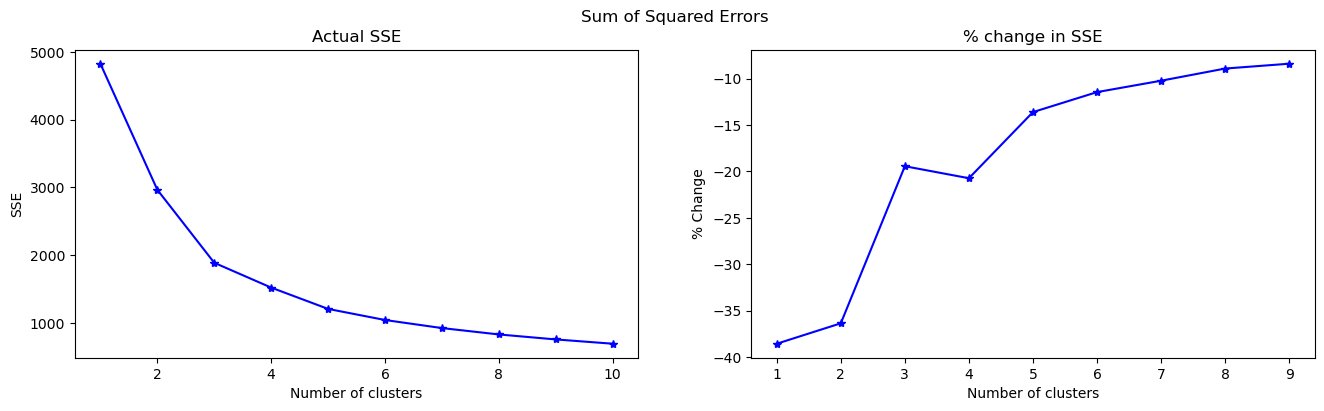

In [57]:
sse_eval(sse)

In [64]:
# num of clusters
num_of_k_means_clusters = 5
# Build a K-means clustering model
km = KMeans(n_clusters=num_of_k_means_clusters, n_init=20, max_iter=300, random_state=1)
# Fit the Model on our dataset
km.fit(rfm_Table_Scaled)
# Assign each data object/point to the cluster represented by its nearest centroid
y_pred = km.predict(rfm_Table_Scaled)

In [ ]:
# Define a custom color palette
custom_palette_k_means = sns.color_palette("tab10", n_colors=num_of_k_means_clusters)
custom_palette_k_means

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

In [65]:
# Add in cluster information into original dataframe (dat)
rfm_Table['kmeans_cluster']=y_pred

C:\Users\ryanl\AppData\Local\Temp\ipykernel_22336\1606919577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_Table['kmeans_cluster']=y_pred


C:\Users\ryanl\AppData\Local\Temp\ipykernel_22336\3805783098.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, (ax,row) in box.iteritems():
C:\Users\ryanl\AppData\Local\Temp\ipykernel_22336\3805783098.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, (ax,row) in box.iteritems():
C:\Users\ryanl\AppData\Local\Temp\ipykernel_22336\3805783098.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for row_key, (ax,row) in box.iteritems():


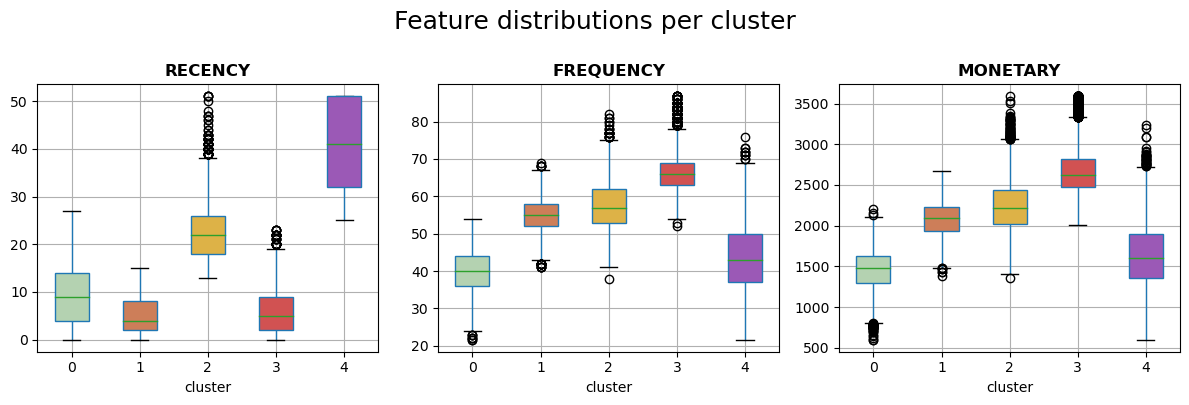

In [71]:
cluster_colors = ['#b4d2b1', '#cd7e59', '#ddb247', '#d15252', '#9b59b6', '#3498db', '#f39c12']
# Add in cluster information into original dataframe (dat)


# Groupped Boxplots

features = ['RECENCY','FREQUENCY','MONETARY']
ncols = 3
nrows = len(features) // ncols + (len(features) % ncols > 0)
fig = plt.figure(figsize=(12,4))

for n, feature in enumerate(features):
    ax = plt.subplot(nrows, ncols, n + 1)
    box = rfm_Table[[feature, 'kmeans_cluster']].boxplot(by='kmeans_cluster',ax=ax,return_type='both',patch_artist = True)

    for row_key, (ax,row) in box.iteritems():
        ax.set_xlabel('cluster')
        ax.set_title(feature,fontweight="bold")
        for i,box in enumerate(row['boxes']):
            box.set_facecolor(cluster_colors[i])

fig.suptitle('Feature distributions per cluster', fontsize=18, y=1)   
plt.tight_layout()
plt.show()

In [68]:
analysis_df=rfm_Table[['RECENCY','FREQUENCY','MONETARY','kmeans_cluster']]

In [70]:
# Step 1: Group the DataFrame by 'kmeans_cluster'
cluster_groups = analysis_df.groupby('kmeans_cluster')

# Step 2: Iterate through each cluster group and apply .info() function
for cluster, cluster_df in cluster_groups:
    print(f"Cluster {cluster} Description:")
    print(cluster_df.describe())
    print("------------")

Cluster 0 Description:
           RECENCY    FREQUENCY     MONETARY  kmeans_cluster
count  9290.000000  9290.000000  9290.000000          9290.0
mean      9.553068    39.781310  1458.943453             0.0
std       6.481906     5.345058   234.064532             0.0
min       0.000000    21.686715   600.087054             0.0
25%       4.000000    36.000000  1300.750000             0.0
50%       9.000000    40.000000  1478.250000             0.0
75%      14.000000    44.000000  1632.250000             0.0
max      27.000000    54.000000  2207.750000             0.0
------------
Cluster 1 Description:
            RECENCY     FREQUENCY      MONETARY  kmeans_cluster
count  15648.000000  15648.000000  15648.000000         15648.0
mean       5.247572     54.783998   2080.233832             1.0
std        3.965104      4.485876    204.348227             0.0
min        0.000000     41.000000   1381.750000             1.0
25%        2.000000     52.000000   1934.000000             1.0
50%     

**Cluster 0: "Active Moderate-Value Customers"**
- Description: This cluster represents customers who are active, show moderate recency (recent purchases), and have a moderate level of spending (moderate monetary value).

**Cluster 1: "Inactive Low-Spending Customers"**
- Description: This cluster consists of customers who exhibit high recency (longest inactivity), low spending (lowest monetary value), and have low purchase frequency (low frequency). These customers are currently inactive and have not made recent purchases.

**Cluster 2: "High-Value Loyal Customers"**
- Description: This cluster includes customers who are both high-value and highly loyal to the business. They have moderate recency (recent purchases), a high purchase frequency (high frequency), and spend significantly (high monetary value). These customers are the most valuable and loyal members, representing a critical segment for the business's ongoing success.

**Cluster 3: "Engaged Moderate-Value Customers"**
- Description: This cluster comprises customers who show moderate recency (recent purchases), a moderate purchase frequency (moderate frequency), and have a moderate level of spending (moderate monetary value). They are actively engaged with the brand and contribute to the business's success.

**Cluster 4: "Active Low-Spending Customers"**
- Description: This cluster consists of customers who have made recent purchases (moderate recency), but their spending is relatively low (low monetary value). They exhibit moderate purchase frequency (moderate frequency) and represent an active but low-spending segment.

In [ ]:
# range_n_clusters = [2, 3, 4, 5, 6]

# for n_clusters in range_n_clusters:
#     # Create a subplot with 1 row and 1 column (removed ax2)
#     fig, ax1 = plt.subplots(1, 1)
#     fig.set_size_inches(12, 7)

#     ax1.set_xlim([-0.1, 1])
#     ax1.set_ylim([0, len(cust_seg_after_scaling) + (n_clusters + 1) * 10])

#     clusterer = KMeans(n_clusters=n_clusters, n_init=20, max_iter=300, random_state=1)
#     cluster_labels = clusterer.fit_predict(cust_seg_after_scaling)

#     silhouette_avg = silhouette_score(cust_seg_after_scaling, cluster_labels)
#     print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

#     sample_silhouette_values = silhouette_samples(cust_seg_after_scaling, cluster_labels)

#     y_lower = 10
#     for i in range(n_clusters):
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#         ith_cluster_silhouette_values.sort()
#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i
#         color = cm.nipy_spectral(float(i) / n_clusters)
#         ax1.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
#         y_lower = y_upper + 10

#     ax1.set_title("The silhouette plot for the various clusters.")
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
#     ax1.set_yticks([])
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     plt.suptitle(
#         "Silhouette analysis for Hierarchical clustering on sample data with n_clusters = %d"
#         % n_clusters,
#         fontsize=14,
#         fontweight="bold",
#     )

# plt.show()

In [ ]:
Kmodes

In [95]:
demo_df=cust_seg_ori.copy()

In [96]:
demo_df['CHILDREN_COUNT'] = demo_df['CHILDREN_COUNT'].map({
    '0': "No",
    '1': "Yes",
    '2': "Yes",
    '3': "Yes",
    '4': "Yes",
    '5+': "Yes",
    'Undisclosed':'Undisclosed'})

demo_df.rename({'CHILDREN_COUNT':'HAVE_CHILDREN'},inplace=True,errors='ignore',axis=1)

In [97]:
demo_df=demo_df[['GENDER','MARITAL_STATUS','CITY','HAVE_CHILDREN','AGE']]

In [102]:
# Define the age groups and corresponding labels
age_bins = [15, 26, 46, 66, 83]
age_labels = ['Young Adults', 'Adults', 'Middle-Aged Adults', 'Seniors']

# Bin the age column based on the age groups and labels
demo_df['AGE_GROUP'] = pd.cut(demo_df['AGE'], bins=age_bins, labels=age_labels)


In [83]:
from kmodes.kmodes import KModes

In [104]:
demo_df.drop('AGE',axis=1,inplace=True,errors='ignore')

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 144727.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 144727.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 144727.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 144727.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 144727.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 105680.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 14030, cost: 105576.0
Run 2, iteration: 2/100, moves: 6975, cost: 105576.0
Init: initi

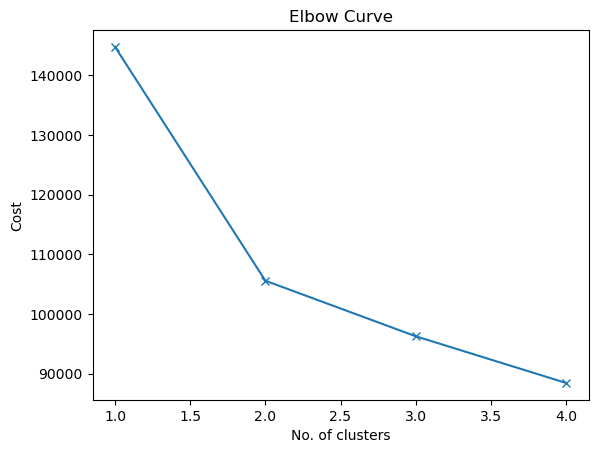

In [105]:
# Elbow curve to find optimal K
cost = []
K = range(1,5)
for k in list(K):
    kmode = KModes(n_clusters=k, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(demo_df)
    cost.append(kmode.cost_)
      
plt.plot(K, cost, 'x-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Curve')
plt.show()

In [107]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=2, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(demo_df)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 12905, cost: 105917.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7923, cost: 107264.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 110110.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 6584, cost: 107673.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 110224.0
Best run was number 1


In [109]:
demo_df['kmodes_cluster']=clusters 

In [112]:
demo_df[demo_df['kmodes_cluster']==0]

,GENDER,MARITAL_STATUS,CITY,HAVE_CHILDREN,AGE_GROUP,kmodes_cluster
0,Male,Married,San Mateo,Yes,Seniors,0
2,Male,Married,San Mateo,Yes,Middle-Aged Adults,0
3,Male,Divorced/Seperated,San Mateo,Yes,Middle-Aged Adults,0
5,Male,Single,San Mateo,No,Adults,0
6,Male,Single,San Mateo,No,Seniors,0
...,...,...,...,...,...,...
46292,Female,Married,Seattle,Yes,Young Adults,0
46295,Female,Married,Seattle,Yes,Seniors,0
46296,Female,Married,New York City,Yes,Middle-Aged Adults,0
46298,Female,Married,San Mateo,Yes,Middle-Aged Adults,0


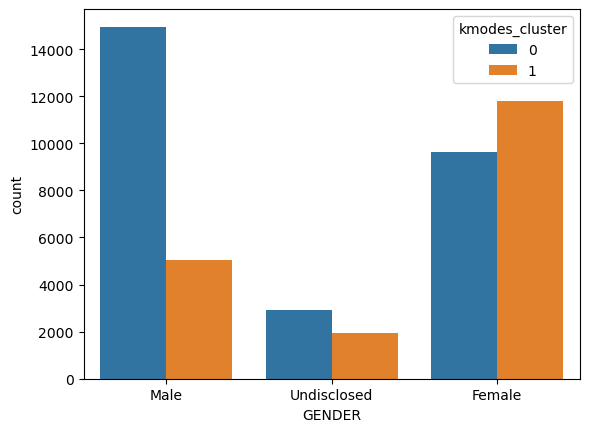

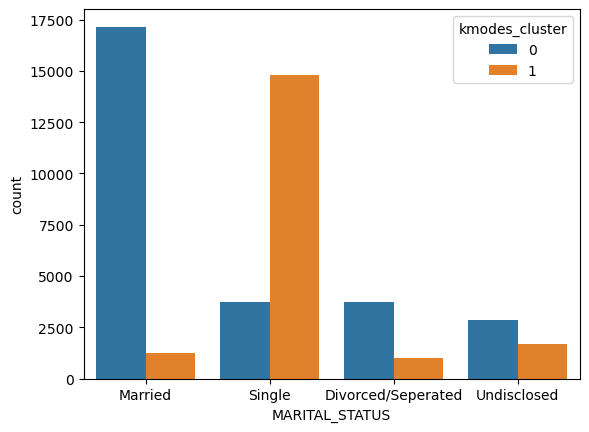

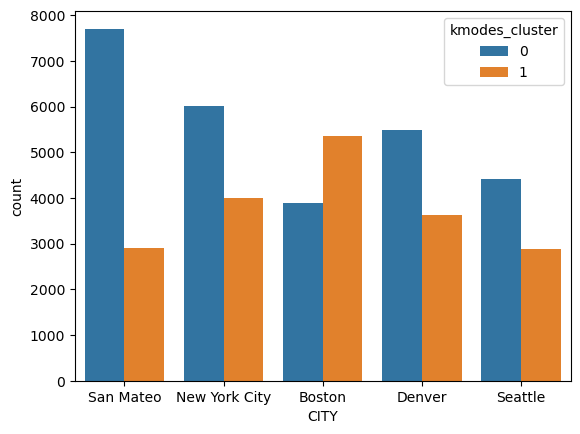

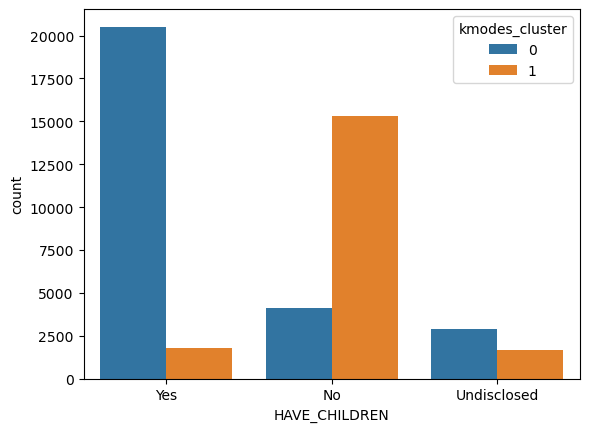

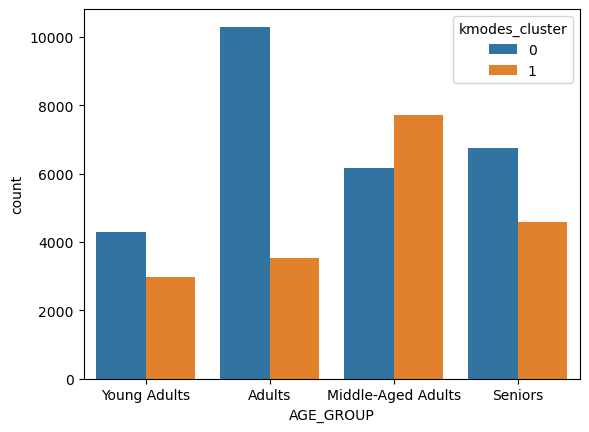

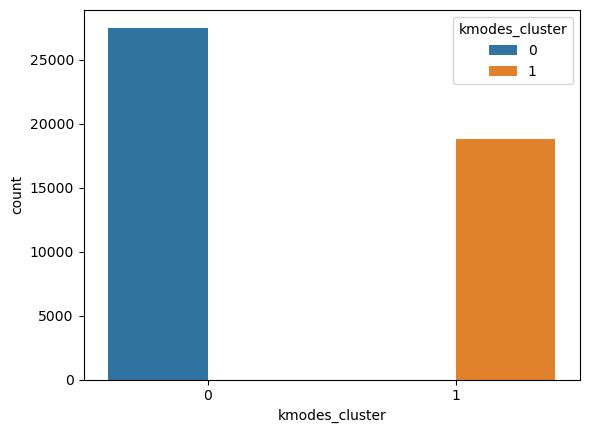

In [116]:
for i in demo_df.columns:
    sns.countplot(x=i,data=demo_df,hue='kmodes_cluster')
    plt.show()